# Eval 6: Embedding Pathway Analysis

**Biological question**: Do learned embeddings capture known biological relationships?

**Part A - Gene Embedding Pathway Recovery**: Do genes in the same pathway cluster together in the encoder's learned gene embeddings?

**Part B - Action Vector Interpretability**: Do perturbations targeting genes in the same pathway produce similar action vectors?

**Metrics**: Silhouette score (clustering quality), k-NN accuracy (local neighborhood preserves pathway membership)

## Setup

In [1]:
import sys
sys.path.insert(0, '..')

import torch
import numpy as np
import json
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from collections import Counter

from eval_common import get_paths, load_biojepa_model, load_perturbation_bank, update_eval_report
from pathway_utils import load_pathway_annotations, map_genes_to_pathways, compute_pathway_clustering_metrics, get_pathway_summary

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device}')

paths = get_paths()
biojepa = load_biojepa_model(paths, device)

Using cpu
<All keys matched successfully>


## Load Pathway Annotations

In [3]:
pathway_libs = load_pathway_annotations(['KEGG_2021_Human', 'Reactome_Pathways_2024'])

Loading KEGG_2021_Human...
  320 pathways loaded
Loading Reactome_Pathways_2024...
  2100 pathways loaded


In [4]:
with open(paths['data_dir'] / 'gene_names.json') as f:
    gene_names = json.load(f)
print(f'Loaded {len(gene_names)} gene names')

Loaded 5000 gene names


---
## Part A: Gene Embedding Pathway Recovery

Extract the learned gene embeddings from the encoder and measure whether genes in the same pathway cluster together.

In [5]:
gene_embeddings = biojepa.student.gene_embeddings.detach().cpu().numpy()
print(f'Gene embeddings shape: {gene_embeddings.shape}')

Gene embeddings shape: (5000, 8)


In [6]:
gene_labels_kegg, pathway_to_genes_kegg = map_genes_to_pathways(gene_names, pathway_libs['KEGG_2021_Human'], min_pathway_size=15, max_pathway_size=300)
kegg_summary = get_pathway_summary(pathway_to_genes_kegg)
print(f'KEGG: {kegg_summary["total_pathways"]} pathways covering {len(gene_labels_kegg)} genes')
print(f'Top pathways by size: {[p[0][:40] for p in kegg_summary["top_pathways"][:5]]}')

KEGG: 234 pathways covering 1847 genes
Top pathways by size: ['Endocytosis', 'Protein processing in endoplasmic reticu', 'Cell cycle', 'Coronavirus disease', 'Apoptosis']


In [7]:
gene_labels_reactome, pathway_to_genes_reactome = map_genes_to_pathways(gene_names, pathway_libs['Reactome_Pathways_2024'], min_pathway_size=15, max_pathway_size=300)
reactome_summary = get_pathway_summary(pathway_to_genes_reactome)
print(f'Reactome: {reactome_summary["total_pathways"]} pathways covering {len(gene_labels_reactome)} genes')
print(f'Top pathways by size: {[p[0][:40] for p in reactome_summary["top_pathways"][:5]]}')

Reactome: 429 pathways covering 2772 genes
Top pathways by size: ['Antigen Processing Ubiquitination & Prot', 'Chromatin Modifying Enzymes', 'Aerobic Respiration and Respiratory Elec', 'Processing of Capped Intron-Containing P', 'CDC42 GTPase Cycle']


### Gene Embedding Clustering Metrics

In [8]:
kegg_gene_indices = list(set(idx for indices in pathway_to_genes_kegg.values() for idx in indices))
kegg_gene_embeddings = gene_embeddings[kegg_gene_indices]
kegg_gene_labels = [gene_labels_kegg[gene_names[i].upper()] for i in kegg_gene_indices]

gene_kegg_metrics = compute_pathway_clustering_metrics(kegg_gene_embeddings, kegg_gene_labels, min_samples_per_class=10)
print('KEGG Gene Embedding Metrics:')
print(f'  Silhouette Score: {gene_kegg_metrics["silhouette_score"]:.4f}')
print(f'  k-NN Accuracy: {gene_kegg_metrics["knn_accuracy"]:.4f}')
print(f'  Classes: {gene_kegg_metrics["n_classes"]}, Samples: {gene_kegg_metrics["n_samples"]}')

KEGG Gene Embedding Metrics:
  Silhouette Score: -0.2233
  k-NN Accuracy: 0.2632
  Classes: 54, Samples: 1140


In [9]:
reactome_gene_indices = list(set(idx for indices in pathway_to_genes_reactome.values() for idx in indices))
reactome_gene_embeddings = gene_embeddings[reactome_gene_indices]
reactome_gene_labels = [gene_labels_reactome[gene_names[i].upper()] for i in reactome_gene_indices]

gene_reactome_metrics = compute_pathway_clustering_metrics(reactome_gene_embeddings, reactome_gene_labels, min_samples_per_class=10)
print('Reactome Gene Embedding Metrics:')
print(f'  Silhouette Score: {gene_reactome_metrics["silhouette_score"]:.4f}')
print(f'  k-NN Accuracy: {gene_reactome_metrics["knn_accuracy"]:.4f}')
print(f'  Classes: {gene_reactome_metrics["n_classes"]}, Samples: {gene_reactome_metrics["n_samples"]}')

Reactome Gene Embedding Metrics:
  Silhouette Score: -0.2485
  k-NN Accuracy: 0.2557
  Classes: 73, Samples: 1592


### Gene Embedding Visualization

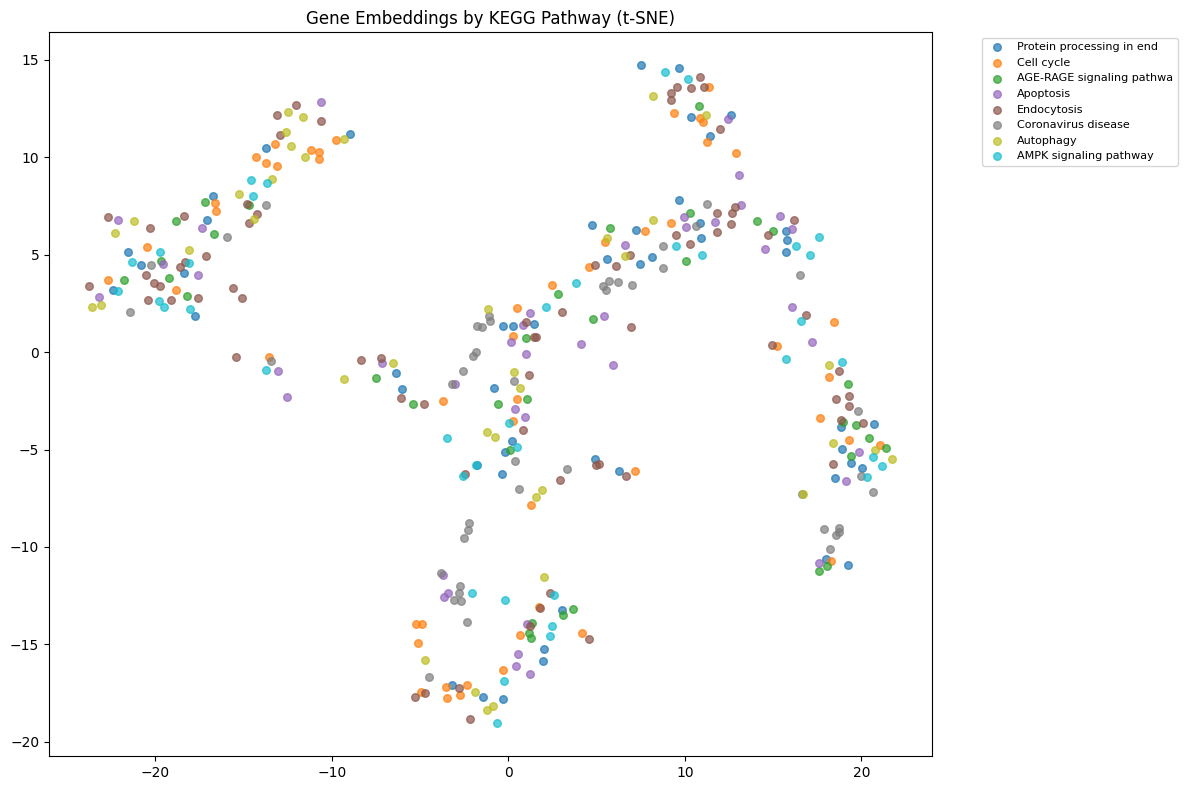

In [10]:
top_kegg_pathways = [p[0] for p in kegg_summary['top_pathways'][:8]]
viz_indices, viz_labels = [], []
for pathway in top_kegg_pathways:
    for idx in pathway_to_genes_kegg.get(pathway, []):
        viz_indices.append(idx)
        viz_labels.append(pathway[:25])

if len(viz_indices) > 50:
    viz_embeddings = gene_embeddings[viz_indices]
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    viz_2d = tsne.fit_transform(viz_embeddings)

    plt.figure(figsize=(12, 8))
    unique_labels = list(set(viz_labels))
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))
    for i, label in enumerate(unique_labels):
        mask = np.array(viz_labels) == label
        plt.scatter(viz_2d[mask, 0], viz_2d[mask, 1], c=[colors[i]], label=label, alpha=0.7, s=30)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    plt.title('Gene Embeddings by KEGG Pathway (t-SNE)')
    plt.tight_layout()
    plt.show()
else:
    print('Not enough genes for visualization')

---
## Part B: Action Vector Interpretability

Extract action vectors for all perturbations and measure whether perturbations targeting genes in the same pathway cluster together.

In [11]:
input_bank = load_perturbation_bank(paths, device)

with open(paths['pert_dir'] / 'input_to_id.json') as f:
    input_to_id = json.load(f)

id_to_gene = {}
for pert_key, pert_id in input_to_id.items():
    gene_name = pert_key.split('_')[0].upper()
    id_to_gene[pert_id] = gene_name

print(f'Loaded {len(id_to_gene)} perturbation -> gene mappings')

Input Bank (DNA): torch.Size([1250, 1536])
Loaded 1250 perturbation -> gene mappings


In [12]:
n_perts = input_bank.shape[0]
p_mod = torch.zeros(n_perts, dtype=torch.long, device=device)
p_mode = torch.zeros(n_perts, dtype=torch.long, device=device)

with torch.no_grad():
    action_vectors = biojepa.composer(input_bank, p_mod, p_mode).cpu().numpy()

print(f'Action vectors shape: {action_vectors.shape}')

Action vectors shape: (1250, 320)


In [13]:
gene_to_pathway_kegg = {}
for pathway, genes in pathway_libs['KEGG_2021_Human'].items():
    if 15 <= len(genes) <= 300:
        for gene in genes:
            if gene.upper() not in gene_to_pathway_kegg:
                gene_to_pathway_kegg[gene.upper()] = pathway

pert_pathway_labels = {}
for pert_id, gene in id_to_gene.items():
    if gene in gene_to_pathway_kegg:
        pert_pathway_labels[pert_id] = gene_to_pathway_kegg[gene]

print(f'Perturbations with KEGG pathway labels: {len(pert_pathway_labels)}')

Perturbations with KEGG pathway labels: 636


### Action Vector Clustering Metrics

In [14]:
action_indices = list(pert_pathway_labels.keys())
action_embeddings = action_vectors[action_indices]
action_labels = [pert_pathway_labels[i] for i in action_indices]

action_kegg_metrics = compute_pathway_clustering_metrics(action_embeddings, action_labels, min_samples_per_class=5)
print('KEGG Action Vector Metrics:')
print(f'  Silhouette Score: {action_kegg_metrics["silhouette_score"]:.4f}')
print(f'  k-NN Accuracy: {action_kegg_metrics["knn_accuracy"]:.4f}')
print(f'  Classes: {action_kegg_metrics["n_classes"]}, Samples: {action_kegg_metrics["n_samples"]}')

KEGG Action Vector Metrics:
  Silhouette Score: -0.4125
  k-NN Accuracy: 0.3709
  Classes: 27, Samples: 515


### Action Vector Visualization

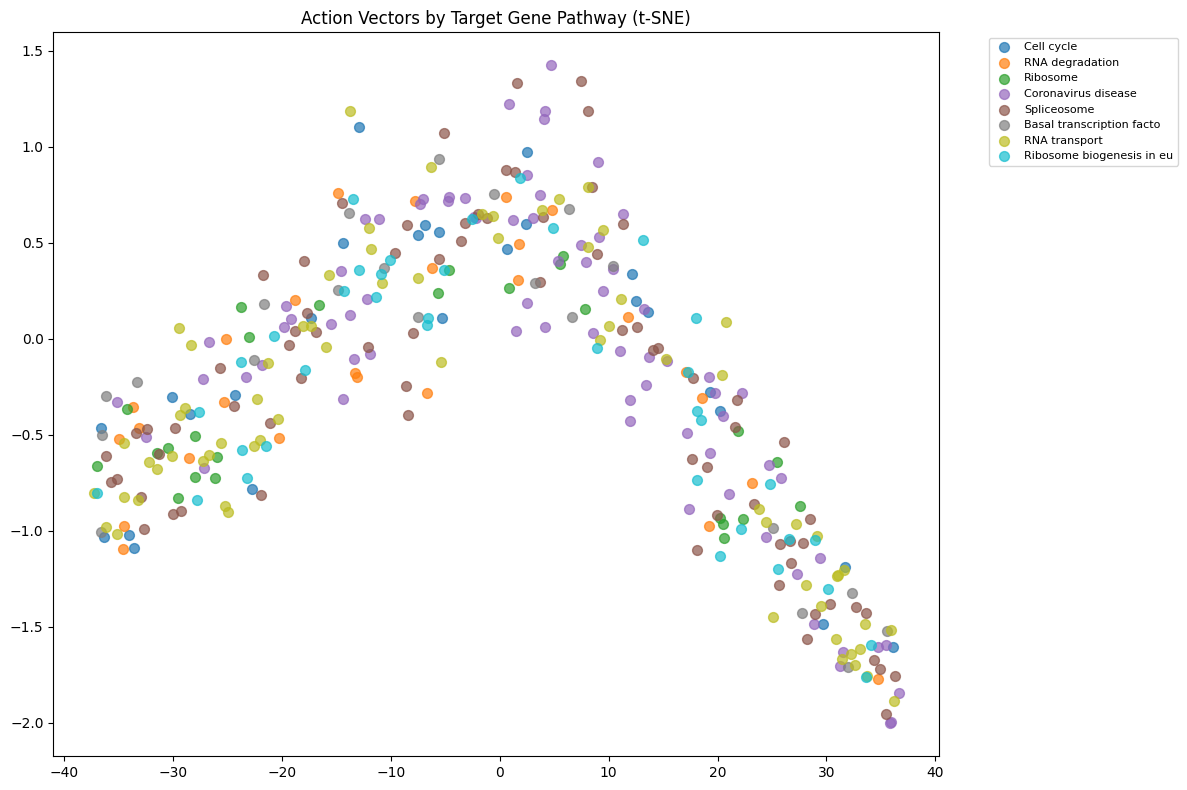

In [15]:
pathway_counts = Counter(action_labels)
top_action_pathways = [p for p, c in pathway_counts.most_common(8) if c >= 5]

viz_action_indices, viz_action_labels = [], []
for pert_id, pathway in pert_pathway_labels.items():
    if pathway in top_action_pathways:
        viz_action_indices.append(pert_id)
        viz_action_labels.append(pathway[:25])

if len(viz_action_indices) > 30:
    viz_action_embeddings = action_vectors[viz_action_indices]
    tsne = TSNE(n_components=2, perplexity=min(30, len(viz_action_indices) // 2), random_state=42)
    viz_action_2d = tsne.fit_transform(viz_action_embeddings)

    plt.figure(figsize=(12, 8))
    unique_labels = list(set(viz_action_labels))
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))
    for i, label in enumerate(unique_labels):
        mask = np.array(viz_action_labels) == label
        plt.scatter(viz_action_2d[mask, 0], viz_action_2d[mask, 1], c=[colors[i]], label=label, alpha=0.7, s=50)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    plt.title('Action Vectors by Target Gene Pathway (t-SNE)')
    plt.tight_layout()
    plt.show()
else:
    print('Not enough perturbations for visualization')

---
## Summary

In [16]:
print('='*70)
print('EVAL 6: EMBEDDING PATHWAY ANALYSIS - RESULTS')
print('='*70)
print()
print('PART A: GENE EMBEDDING PATHWAY RECOVERY')
print('-'*40)
print(f'KEGG Pathways:')
print(f'  Silhouette Score: {gene_kegg_metrics["silhouette_score"]:.4f}')
print(f'  k-NN Accuracy:    {gene_kegg_metrics["knn_accuracy"]:.4f}')
print(f'  Pathways: {gene_kegg_metrics["n_classes"]}, Genes: {gene_kegg_metrics["n_samples"]}')
print()
print(f'Reactome Pathways:')
print(f'  Silhouette Score: {gene_reactome_metrics["silhouette_score"]:.4f}')
print(f'  k-NN Accuracy:    {gene_reactome_metrics["knn_accuracy"]:.4f}')
print(f'  Pathways: {gene_reactome_metrics["n_classes"]}, Genes: {gene_reactome_metrics["n_samples"]}')
print()
print('PART B: ACTION VECTOR INTERPRETABILITY')
print('-'*40)
print(f'KEGG Pathways:')
print(f'  Silhouette Score: {action_kegg_metrics["silhouette_score"]:.4f}')
print(f'  k-NN Accuracy:    {action_kegg_metrics["knn_accuracy"]:.4f}')
print(f'  Pathways: {action_kegg_metrics["n_classes"]}, Perturbations: {action_kegg_metrics["n_samples"]}')
print()
print('INTERPRETATION')
print('-'*40)
print('Silhouette: -1 to 1, higher = better clustering. >0.1 is meaningful.')
print('k-NN Accuracy: Chance = 1/n_classes. Higher = pathway neighbors preserved.')

EVAL 6: EMBEDDING PATHWAY ANALYSIS - RESULTS

PART A: GENE EMBEDDING PATHWAY RECOVERY
----------------------------------------
KEGG Pathways:
  Silhouette Score: -0.2233
  k-NN Accuracy:    0.2632
  Pathways: 54, Genes: 1140

Reactome Pathways:
  Silhouette Score: -0.2485
  k-NN Accuracy:    0.2557
  Pathways: 73, Genes: 1592

PART B: ACTION VECTOR INTERPRETABILITY
----------------------------------------
KEGG Pathways:
  Silhouette Score: -0.4125
  k-NN Accuracy:    0.3709
  Pathways: 27, Perturbations: 515

INTERPRETATION
----------------------------------------
Silhouette: -1 to 1, higher = better clustering. >0.1 is meaningful.
k-NN Accuracy: Chance = 1/n_classes. Higher = pathway neighbors preserved.


In [17]:
update_eval_report('eval_6_embedding_pathways', {
    'config': {
        'n_genes': len(gene_names),
        'n_perturbations': len(id_to_gene),
        'pathway_libraries': ['KEGG_2021_Human', 'Reactome_Pathways_2024']
    },
    'gene_embeddings': {
        'kegg': gene_kegg_metrics,
        'reactome': gene_reactome_metrics
    },
    'action_vectors': {
        'kegg': action_kegg_metrics
    }
})

Updated eval_report.json
